# Syllables Analysis & Derégnaucourt replication

This notebook contains statistical analyses done by Derégnaucourt et al. (2005). Our goal is to reproduce the results of this paper.

In [227]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join, isdir, exists
import json
import pandas as pd
import pickle
from scipy.io import wavfile
from syllable_cluster import *

from ipywidgets.widgets import FloatProgress
from IPython.display import display

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib inline

Extract the data from all the bird in the simulation.

In [228]:
import itertools
progress = FloatProgress(min=0, max=1)
display(progress)
main_path = '../model/res/diversity_weight/seed{}+big_ba+50_conc+3_day_conc+{}_diversity_weight/'
all_dat = []

for seed, div in itertools.product(range(40), [10, 15, 2, 3]):
    if not isdir(main_path.format(seed, div)) or not exists(join(main_path.format(seed, div), 'data_cur.pkl')):
        continue
    path = main_path.format(seed, div)
    cur_dat = syllables_from_run(path, force=False, progress=progress)
    cur_dat['bird'] = seed * 1000 + div
    cur_dat['div'] = div
    all_dat.append(cur_dat)
    seed += 1
all_dat = pd.concat(all_dat)

sr, tutor = wavfile.read(join(main_path.format(10, 1), 'tutor.wav'))
tutor_syllables = extract_syllables_statistics(tutor)

In [229]:
pad = 20


In [230]:
all_dat

,beg,comb,day,end,isong,isyb,length,mam,mamplitude,mentropy,...,mpitch,vam,vamplitude,ventropy,vfm,vgoodness,vpitch,run_name,bird,div
0,0,0.0,0,16,0,0,16,-3.053613,73.375898,-3.435873,...,3130.170674,6.558119e+00,170.704574,0.468501,0.238395,0.000310,1.343488e+06,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
1,145,0.0,0,161,0,1,16,0.000003,41.083859,-2.310663,...,0.000000,5.549720e-09,0.006533,0.000538,0.017950,0.000017,0.000000e+00,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
2,0,0.0,0,16,1,0,16,-3.053613,73.375898,-3.435873,...,3130.170674,6.558119e+00,170.704574,0.468501,0.238395,0.000310,1.343488e+06,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
3,145,0.0,0,161,1,1,16,0.000003,41.083859,-2.310663,...,0.000000,5.549720e-09,0.006533,0.000538,0.017950,0.000017,0.000000e+00,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
4,0,0.0,0,16,2,0,16,-3.053613,73.375898,-3.435873,...,3130.170674,6.558119e+00,170.704574,0.468501,0.238395,0.000310,1.343488e+06,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
5,145,0.0,0,161,2,1,16,0.000003,41.083859,-2.310663,...,0.000000,5.549720e-09,0.006533,0.000538,0.017950,0.000017,0.000000e+00,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
6,65,0.5,0,91,0,0,26,0.000111,55.843534,-2.847753,...,175.800157,5.007310e-04,8.637162,0.095650,0.305733,0.000093,4.256081e+05,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
7,151,0.5,0,218,0,1,67,0.000236,82.614281,-3.867988,...,3382.905937,3.743788e+01,61.386505,0.115608,0.246795,0.001580,2.837334e+05,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
8,270,0.5,0,417,0,2,147,-0.000225,86.079957,-4.137364,...,3451.564156,2.484691e+01,20.023303,0.427006,0.146481,0.003818,7.966948e+04,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10
9,437,0.5,0,463,0,3,26,-0.000046,55.284920,-2.839532,...,187.193647,3.655887e-04,8.473036,0.089075,0.281449,0.000047,5.030573e+05,seed4+big_ba+50_conc+3_day_conc+10_diversity_w...,4010,10


# Study dynamics of syllable progression

In [231]:
all_dat['bird'].unique()

array([ 4010,  4015,  4002,  4003, 10010, 10015, 10002, 10003])

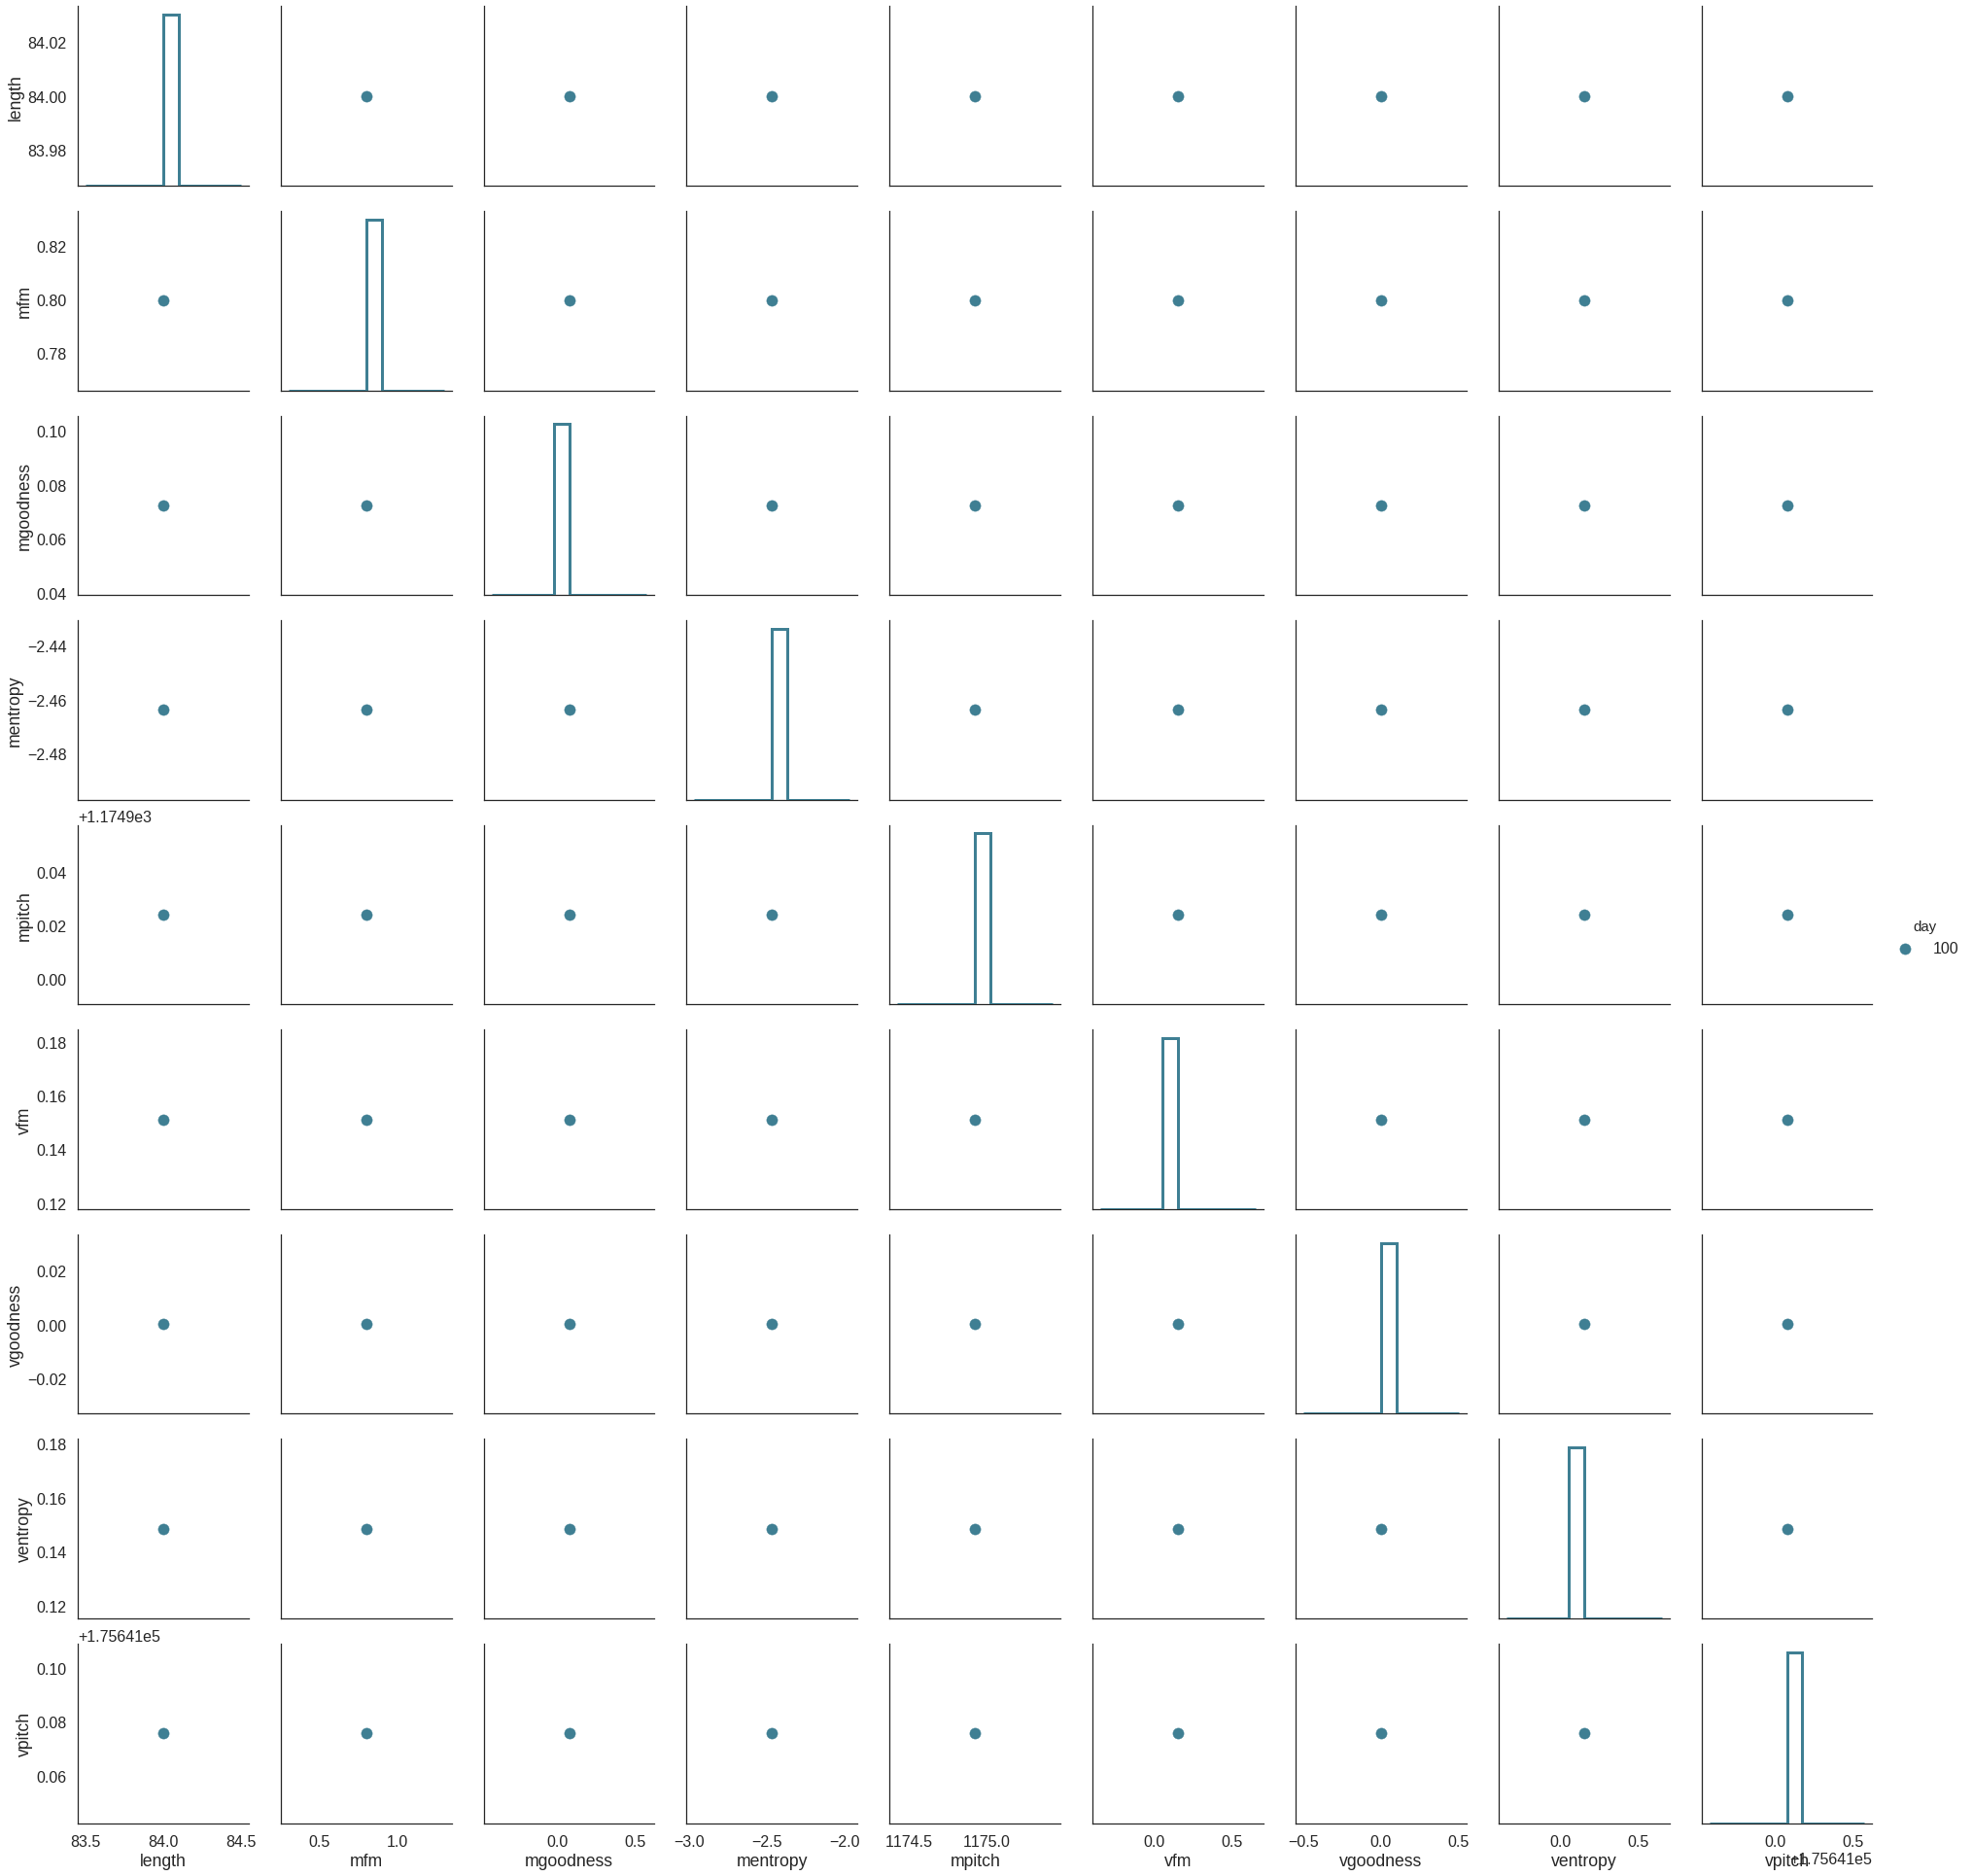

In [232]:
beg = tutor_syllables[0]['beg'] - pad
end = tutor_syllables[0]['end'] + pad
plot_dat = all_dat.query("((bird == {bird}) and ( \
                         (beg > {beg} and end < {end}) and day % 10 == 0))".format(
    bird=2,
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad
))
tutor_df = pd.DataFrame(tutor_syllables)
tutor_df['day'] = 100
plot_dat = pd.concat((plot_dat, tutor_df.query("beg > {beg} and end < {end}".format(beg=beg, end=end))))

g = sns.PairGrid(plot_dat, hue="day", hue_kws={'marker': ['o', 'o', 'o', 'o', 'o', '*']},
                 vars=['length', 'mfm', 'mgoodness', 'mentropy', 'mpitch',
                                            'vfm', 'vgoodness', 'ventropy', 'vpitch'], size=3, palette=sns.diverging_palette(220, 20, n=5))
g.map_diag(plt.hist, histtype="step", linewidth=3)
g.map_offdiag(plt.scatter, alpha=1)
#g.map_offdiag(sns.kdeplot, alpha=0.3)
g.add_legend()


/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


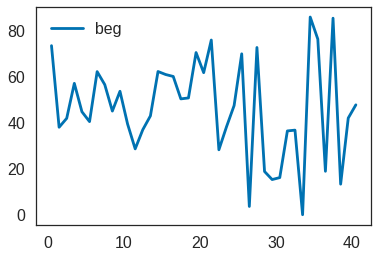

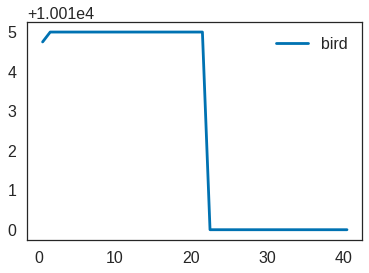

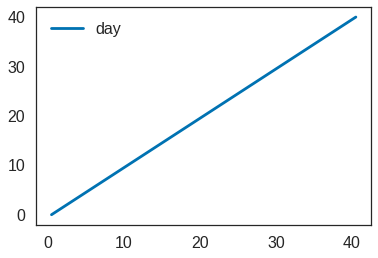

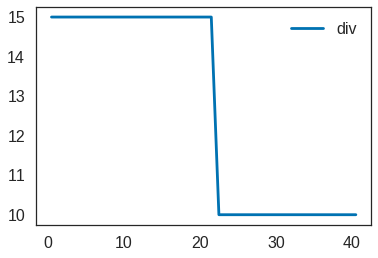

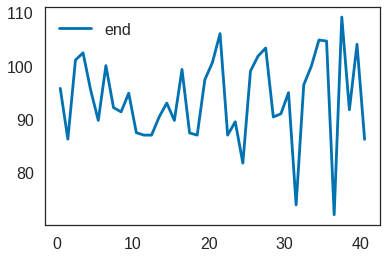

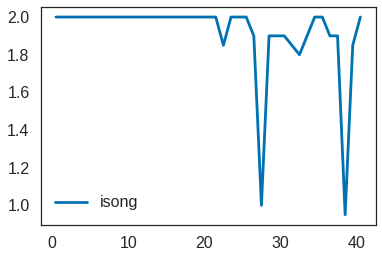

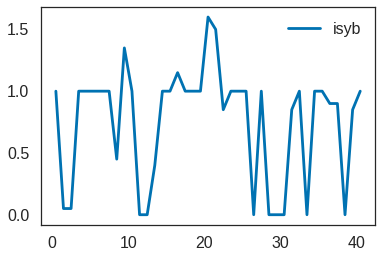

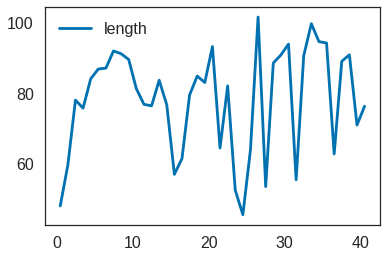

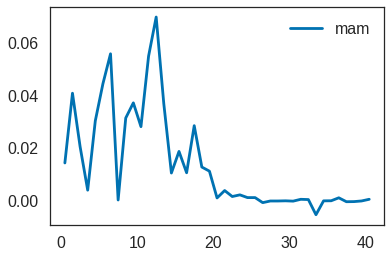

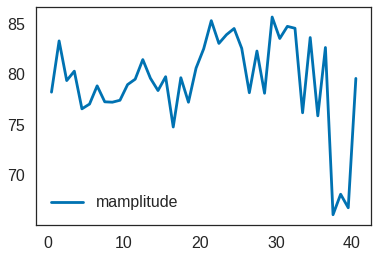

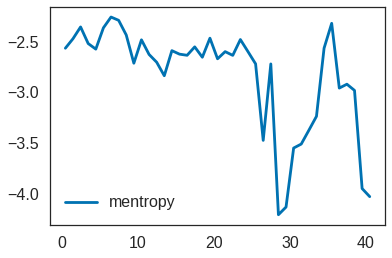

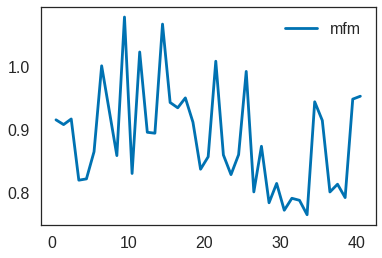

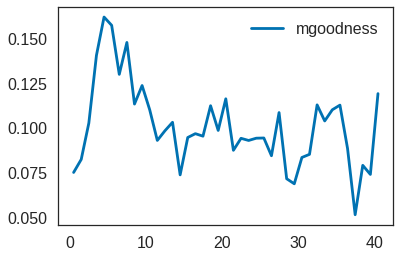

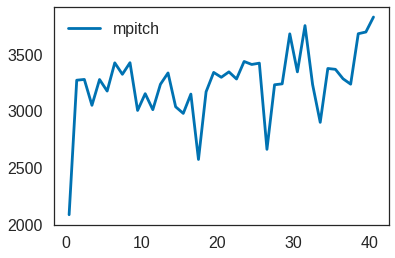

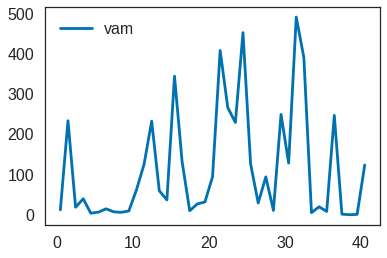

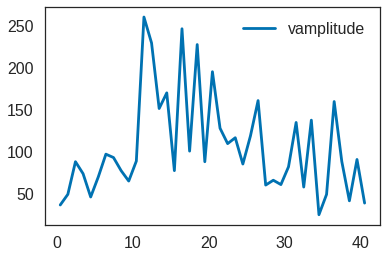

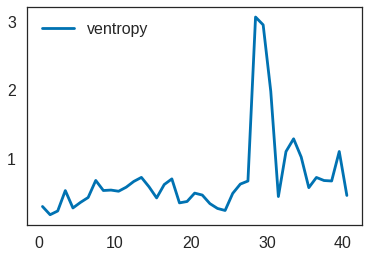

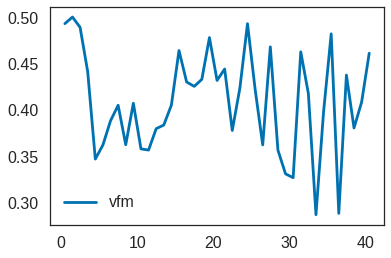

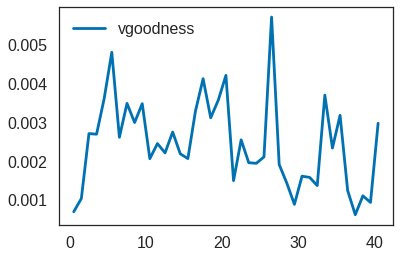

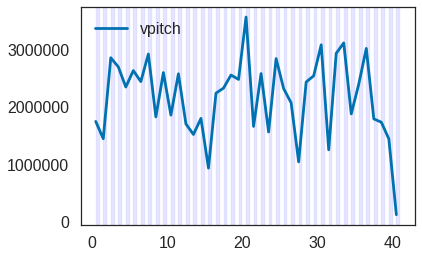

In [233]:
plt.figure(figsize=(14, 14))
med = all_dat.query('beg > {beg} and end < {end} and moment == "evening"'.format(
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad)).groupby('comb').quantile(0.95)
for item in med.keys():
    plt.figure()
    plt.plot(med[item], label=item)
    plt.legend()
for day in range(np.max(all_dat['day'])):
    plt.axvspan(day+0.5, day+1, color='b', alpha=0.1)

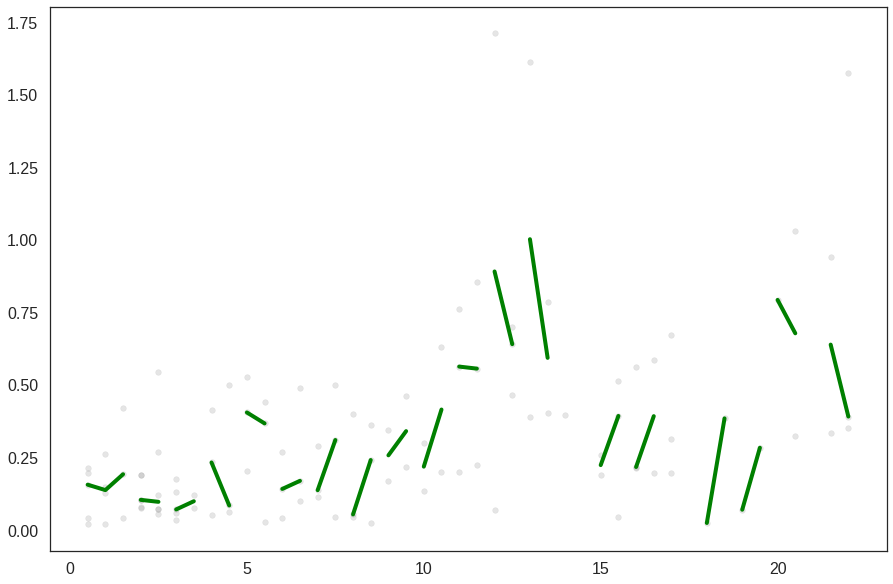

In [234]:
plt.figure(figsize=(15, 10))

feat = 'ventropy'

splitted = all_dat.query("isyb == 3 and div == 15").groupby('comb')[feat].quantile(0.5)
for i in splitted.index:
    if i % 1 == 0:
        splitted.set_value(i + 0.75, np.nan)
splitted.sort_index(inplace=True)


plt.scatter(all_dat.query("isyb == 3 and div == 15")['comb'], all_dat.query("isyb == 3 and div == 15")[feat], marker='.', alpha=0.2, color="grey")
plt.plot(splitted, linewidth=4, color="g")


In [235]:
splitted

comb
0.50     0.157369
1.00     0.138664
1.50     0.193340
1.75          NaN
2.00     0.105055
2.50     0.098238
2.75          NaN
3.00     0.071992
3.50     0.100294
3.75          NaN
4.00     0.233894
4.50     0.085628
4.75          NaN
5.00     0.406340
5.50     0.368661
5.75          NaN
6.00     0.142656
6.50     0.170608
6.75          NaN
7.00     0.138413
7.50     0.311367
7.75          NaN
8.00     0.054831
8.50     0.242409
8.75          NaN
9.00     0.258554
9.50     0.341982
9.75          NaN
10.00    0.219563
10.50    0.416443
           ...   
11.50    0.557491
11.75         NaN
12.00    0.892455
12.50    0.641832
12.75         NaN
13.00    1.003682
13.50    0.594602
13.75         NaN
14.00    0.396611
14.75         NaN
15.00    0.224800
15.50    0.394315
15.75         NaN
16.00    0.218267
16.50    0.393641
16.75         NaN
17.00    0.313771
17.75         NaN
18.00    0.025313
18.50    0.385917
18.75         NaN
19.00    0.071050
19.50    0.284796
19.75         NaN
20.00

# Percent Change analysis

## Percent change absolute values

## Percent change signed values

In [236]:
all_changes = []

features = ['mentropy', 'mfm','mgoodness','vfm','ventropy','vgoodness']
#features = ['ventropy']

# NIGHT

for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day+1, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median().abs() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                if abs(percent_change) > 100:
                    print('*='*40)
                    #print(percent_change_all)
                    #print(first['ventropy'])
                    #print(last['ventropy'])
                all_changes.append({'day': day, 'isyb': isyb, 'bird': bird_n, 'div': bird['div'].iloc[0], 'percent_change':percent_change, 'cond': 'night'})

# DAY
for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median().abs() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                if abs(percent_change) > 100:
                    print('*='*40)
                all_changes.append({'day': day, 'isyb': isyb, 'div': bird['div'].iloc[0], 'bird': bird_n, 'percent_change':percent_change, 'cond': 'day'})


4002
syb: 0
syb: 1
syb: 2
4003
syb: 0
syb: 1
syb: 2
4010
syb: 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 1
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 2
4015
syb: 0
syb: 1
syb: 2
10002
syb: 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 1
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
syb: 2
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
10003
syb: 0
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

In [237]:
change_df = pd.DataFrame(all_changes)
change_df["birdsyb"] = change_df['bird'] * 1000 + change_df['isyb']

change_df = change_df.groupby(('day', 'bird', 'cond')).mean()

change_df = pd.DataFrame(change_df.to_records()).query('-100 <percent_change < 100')


In [238]:
change_df.groupby(('day', 'bird', 'cond')).mean()

div  isyb  percent_change     birdsyb
day bird  cond                                         
0   4002  night   2.0   1.0       22.878338   4002001.0
    4003  night   3.0   1.0        2.600454   4003001.0
    4010  night  10.0   1.5        7.447316   4010001.5
    4015  night  15.0   1.5       22.810718   4015001.5
    10002 night   2.0   1.0        6.897708  10002001.0
    10003 night   3.0   1.0       -0.045804  10003001.0
    10015 night  15.0   1.0       73.192339  10015001.0
1   4002  day     2.0   1.0       17.589075   4002001.0
          night   2.0   1.0        5.245663   4002001.0
    4003  day     3.0   1.0       55.968454   4003001.0
          night   3.0   1.0        0.000000   4003001.0
    4010  day    10.0   1.5       39.929328   4010001.5
          night  10.0   1.5      -26.084078   4010001.5
    4015  night  15.0   1.0       11.594000   4015001.0
    10002 day     2.0   1.0       24.781987  10002001.0
          night   2.0   1.0       18.019637  10002001.0
    10003 day     3.0   1.0       17.521626  10003001.0
    10010 night  10.0   0.5       19.281347  10010000.5
    10015 day    15.0   1.0       35.872916  10015001.0
          night  15.0   1.0       -1.060160  10015001.0
2   4002  day     2.0   1.0       15.369850   4002001.0
          night   2.0   1.0        0.000000   4002001.0
    4010  night  10.0   1.0       35.353931   4010001.0
    4015  day    15.0   1.0       46.784686   4015001.0
          night  15.0   1.0        0.000000   4015001.0
    10002 day     2.0   1.0        2.777007  10002001.0
    10003 day     3.0   1.0        9.099320  10003001.0
          night   3.0   1.0      -28.196539  10003001.0
    10010 day    10.0   1.0       -4.537308  10010001.0
          night  10.0   1.0       15.297493  10010001.0
...               ...   ...             ...         ...
25  10010 night  10.0   1.5       31.112332  10010001.5
26  10010 day    10.0   1.5        8.680865  10010001.5
          night  10.0   0.5      -12.706391  10010000.5
27  10010 day    10.0   0.5       96.737421  10010000.5
          night  10.0   0.5      -20.960533  10010000.5
28  10010 day    10.0   0.5       18.313802  10010000.5
          night  10.0   1.0        5.242960  10010001.0
29  10010 day    10.0   1.0        9.111082  10010001.0
          night  10.0   1.0       -2.304115  10010001.0
30  10010 day    10.0   1.0       -1.155439  10010001.0
          night  10.0   1.0        3.390018  10010001.0
31  10010 day    10.0   1.0        3.272620  10010001.0
          night  10.0   1.0       10.075252  10010001.0
32  10010 day    10.0   1.0       13.430290  10010001.0
          night  10.0   1.0       18.067712  10010001.0
33  10010 day    10.0   1.0        3.967375  10010001.0
          night  10.0   1.0       16.071735  10010001.0
34  10010 day    10.0   1.0        9.787175  10010001.0
35  10010 day    10.0   1.0       15.581965  10010001.0
          night  10.0   1.0        5.941065  10010001.0
36  10010 day    10.0   1.0       19.744622  10010001.0
          night  10.0   1.0        6.467492  10010001.0
37  10010 day    10.0   1.0       16.394173  10010001.0
          night  10.0   1.0        8.007688  10010001.0
38  10010 day    10.0   1.0       -2.899357  10010001.0
          night  10.0   0.5       12.566351  10010000.5
39  10010 day    10.0   0.5       -0.536595  10010000.5
          night  10.0   1.0       14.631646  10010001.0
40  10010 day    10.0   1.0       19.694214  10010001.0
          night  10.0   1.0        0.000000  10010001.0

[212 rows x 4 columns]

/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


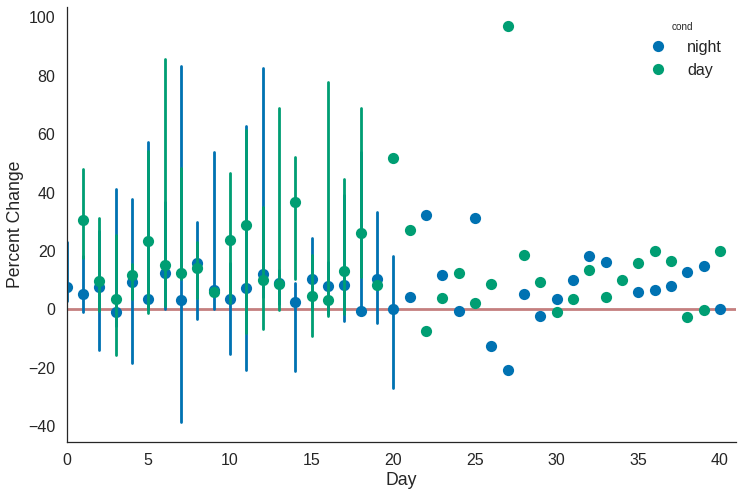

In [239]:
plt.figure(figsize=(12, 8))
plt.axhline(0, c='darkred', alpha=0.5)
sns.tsplot(change_df, time='day', unit='bird', interpolate=False, value='percent_change', condition='cond', err_style='ci_bars', ci=95, estimator=np.nanmedian)
sns.despine()
plt.ylabel("Percent Change")
plt.xlabel('Day')
plt.savefig('per_det.svg')

In [240]:
all_changes_df = pd.DataFrame(all_changes)
night_pc = change_df.query('cond == "night"').groupby('bird').mean()

In [241]:
night_pc

,day,div,isyb,percent_change,birdsyb
bird,,,,,
4002,1.000000,2.0,1.000000,9.374667,4.002001e+06
4003,0.500000,3.0,1.000000,1.300227,4.003001e+06
4010,2.833333,10.0,1.166667,11.655520,4.010001e+06
4015,1.000000,15.0,1.166667,11.468239,4.015001e+06
10002,10.400000,2.0,1.000000,24.104542,1.000200e+07
10003,10.705882,3.0,1.000000,5.432227,1.000300e+07
10010,20.342105,10.0,0.789474,6.629153,1.001000e+07
10015,10.500000,15.0,1.000000,8.305551,1.001500e+07


In [242]:
force = True
try:
    sim
except:
    force = True
if force:
    sim = []
    for bird in night_pc.index:
        i = bird//1000
        div = bird%1000
        try:
            with open(join(main_path.format(i, div), 'data_cur.pkl'), 'rb') as f:
                songlog = pickle.load(f)
        except FileNotFoundError:
            continue
        root_data = [item[1] for item in songlog if item[0] == 'root']
        rd = pd.DataFrame(root_data)
        smodels = rd['songs'].iloc[-1]
        print(i, div, 'beg')
        sim.append(bsa.similarity(smodels[np.argmin(rd['scores'].iloc[-1])].gen_sound(), tutor)['similarity'])
        print(i)

4 2 beg
4
4 3 beg
4
4 10 beg
4
4 15 beg
4
10 2 beg
10
10 3 beg
10
10 10 beg
10
10 15 beg
10


In [243]:
night_pc['percent_change_deterioration'] = -night_pc['percent_change']

night_pc['sim'] = sim

(0, 1)

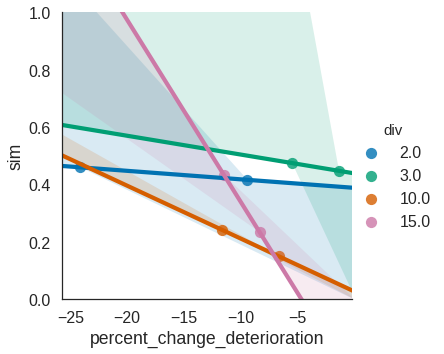

In [244]:

sns.lmplot(x="percent_change_deterioration", y='sim', hue='div', data=night_pc, ci=95)
plt.ylim((0, 1))

In [245]:
from scipy import stats

In [246]:
stats.linregress(night_pc['percent_change_deterioration'], night_pc['sim'])

LinregressResult(slope=-0.0029187884695634245, intercept=0.32929995720617311, rvalue=-0.15394761699807508, pvalue=0.71587646482600298, stderr=0.0076479616205862751)

In [ ]:

with sns.color_palette('Blues', 4):
    plt.figure(figsize=(8, 8))
    ax = sns.regplot(x="percent_change_deterioration", y='sim', data=night_pc, ci=95)
    ax.set_ylim((0, 1))
    for i, div in enumerate([15, 2, 3, 10]):
        if div > 10:
            div /= 10
        ax.scatter(night_pc.query('div == {}'.format(div))['percent_change_deterioration'], list(night_pc.query('div == {}'.format(div))['sim']), label=div)
    ax.legend()